# Qiskit Exercise List 1 Solutions

In [1]:
import numpy as np

from qiskit import transpile
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_circuit_layout
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, pauli_error

from qiskit_ibm_runtime.fake_provider import FakeQuitoV2, FakeOslo

## Exercise 1

(a)  Build a quantum circuit that creates the following three-qubits state

$$| \psi \rangle = \frac{1}{\sqrt{3}} (|100 \rangle + | 010 \rangle + | 001 \rangle), $$

without using the `QuantumCircuit.initialize()` method. Use the `Statevector` class to check that your circuit corresponds to the desired state $|\psi \rangle$. Then, obtain a circuit that prepares the same state, but using only the basis gate set $\{ CX, RZ, SX, X \}$.

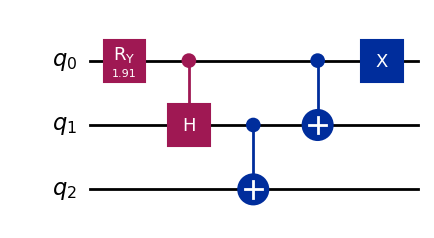

In [2]:
qreg_q = QuantumRegister(3, 'q')
circuit = QuantumCircuit(qreg_q)

circuit.ry(2*np.arccos(1/np.sqrt(3)),qreg_q[0])
circuit.ch(qreg_q[0], qreg_q[1])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.x(qreg_q[0])

circuit.draw('mpl')

In [3]:
# Check that it corresponds to the desire state

psi = (1/np.sqrt(3))*np.array([0,1,1,0,1,0,0,0])
psi_circ = Statevector(circuit).data

print(psi_circ)
print(psi)

print(np.allclose(psi_circ, psi, atol=1e-5))

[0.        +0.j 0.57735027+0.j 0.57735027+0.j 0.        +0.j
 0.57735027+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
[0.         0.57735027 0.57735027 0.         0.57735027 0.
 0.         0.        ]
True


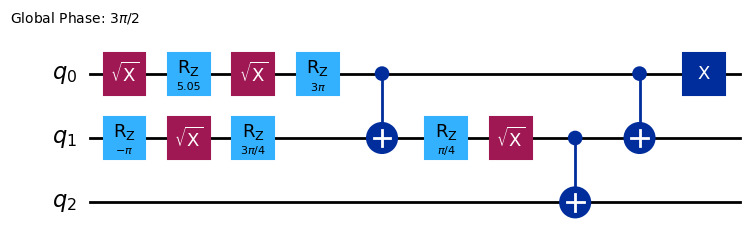

In [4]:
# Obtain the desired circuit using only the basis gates

basis_gates = ['rz', 'x', 'sx', 'cx']
trans_circuit = transpile(circuit, basis_gates=basis_gates)
trans_circuit.draw(output='mpl')

(b) Using the Qiskit Aer Simulator, measure the circuit in the $Z$ basis using 8192 shots. Plot the probability distributions (i.e. the counts) in a histogram plot.

In [5]:
backend = AerSimulator()

circuit_b = trans_circuit.copy()
circuit_b.measure_all(add_bits=True)

results_b = backend.run(circuit_b, shots=8192).result()
counts_b = results_b.get_counts()

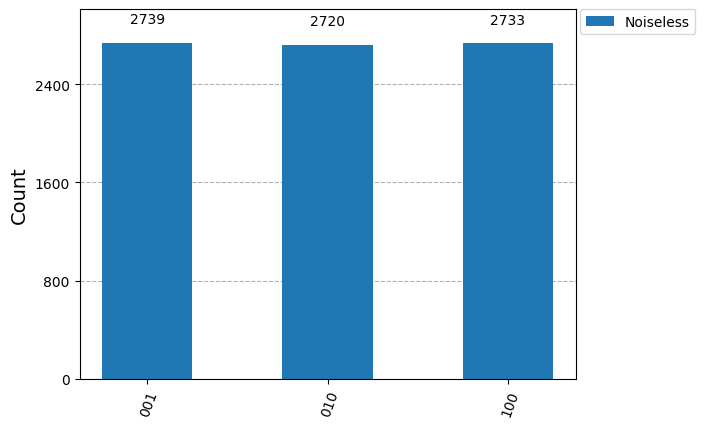

In [6]:
plot_histogram([counts_b], legend=['Noiseless'])

(c) Build the following noise models:

* Noise model that adds a bit-flip channel with $20\%$ error to all measurements (Do not mistake with the ReadoutError).
* Noise model that adds a depolarazing channel with $10\%$ error to the CNOT gate.

Repeat exercise (b) using both models noise model, displaying all experiments in the same histogram plot.

In [7]:
noise_model_1 = NoiseModel()

# Bit-flip channel

p_error_1 = 0.2
bit_flip_chan = pauli_error([('X', p_error_1), ('I', 1 - p_error_1)])

# Add error to the measurements

noise_model_1.add_all_qubit_quantum_error(bit_flip_chan, 'measure')
print(noise_model_1)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['measure']
  All-qubits errors: ['measure']


In [8]:
noise_model_2 = NoiseModel()

# Depolarizing channel

p_error_2 = 0.1       
depol_chan = depolarizing_error(p_error_2, 2)

# Add error to the CNOT gates

noise_model_2.add_all_qubit_quantum_error(depol_chan, ['cx'])
print(noise_model_2)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx']
  Instructions with noise: ['cx']
  All-qubits errors: ['cx']


In [9]:
circuit_c1 = circuit_b.copy()
circuit_c2 = circuit_b.copy()

results_c1 = backend.run(circuit_c1, noise_model=noise_model_1, shots=8192).result()
counts_c1 = results_c1.get_counts()

results_c2 = backend.run(circuit_c2, noise_model=noise_model_2, shots=8192).result()
counts_c2 = results_c2.get_counts()

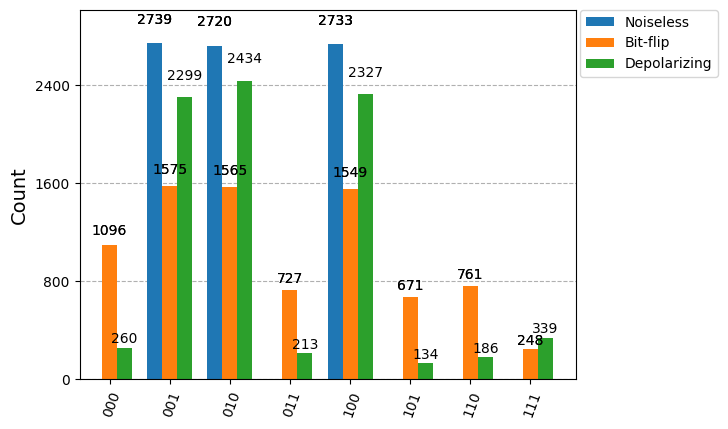

In [10]:
plot_histogram([counts_b, counts_c1, counts_c2], legend=['Noiseless', 'Bit-flip', 'Depolarizing'])

## Exercise 2

(a) Define a function that has as input the number of qubits $N$, and outputs a quantum circuit that implements the $N$-qubits GHZ state given by

$$|GHZ_N \rangle = \frac{1}{\sqrt N} (|0 \rangle^{\otimes N} + |1 \rangle^{\otimes N}) = \frac{1}{\sqrt N} (|0 \ldots 0 \rangle + |1 \ldots 1 \rangle).$$

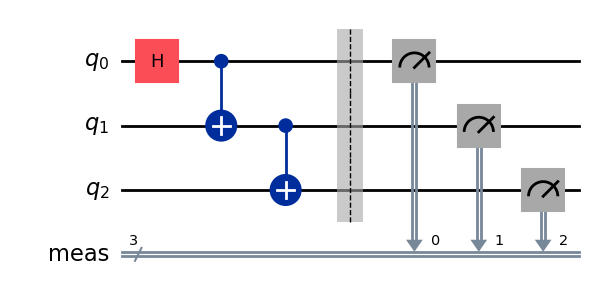

In [11]:
def ghz_state(N):
  qc = QuantumCircuit(N)
  qc.h(0)
  for i in range(N-1):
    qc.cx(i, i+1)
  qc.measure_all()
  return qc

qc = ghz_state(3)
qc.draw('mpl')

(b) Let us consider the following `FakeProvider`'s from Qiskit IBM Runtime: `FakeQuitoV2` and `FakeOslo`. Using the function of exercise (a)

* Perform a simulation of the 5 qubits GHZ-state using 8192 shots using the `FakeQuitoV2` backend.
* Perform a simulation of the 7 qubits GHZ-state using 8192 shots using the `FakeOslo` backend.

For each cases, set the transpile `optimization_level` to 0 (trivial transpilation), and count the number of CNOT gates after transpilation. Plot the probability distributions in a histogram plot in descending order. 

In [12]:
shots = 8192

quito = FakeQuitoV2()
oslo = FakeOslo()

trans_quito = transpile(ghz_state(5), backend=quito, optimization_level=0)
trans_oslo = transpile(ghz_state(7), backend=oslo, optimization_level=0)

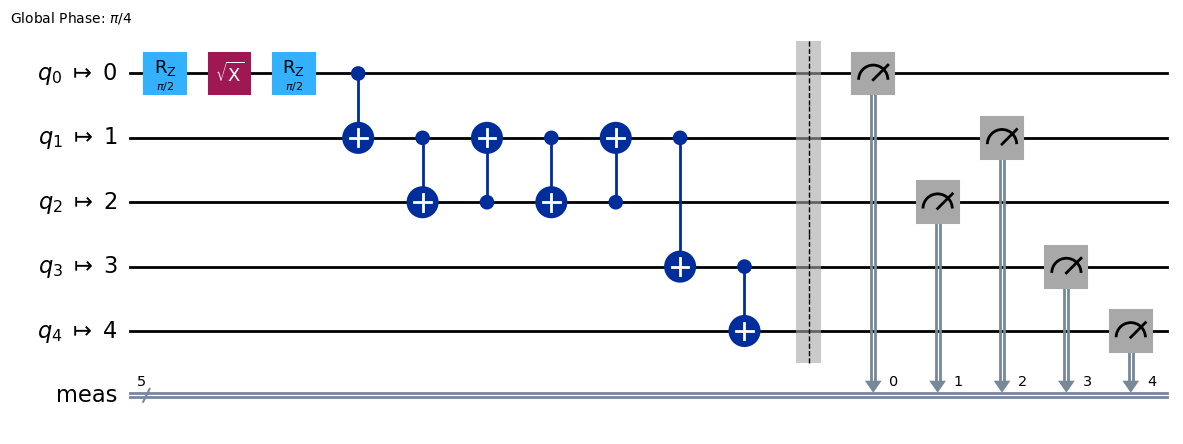

In [13]:
trans_quito.draw('mpl')

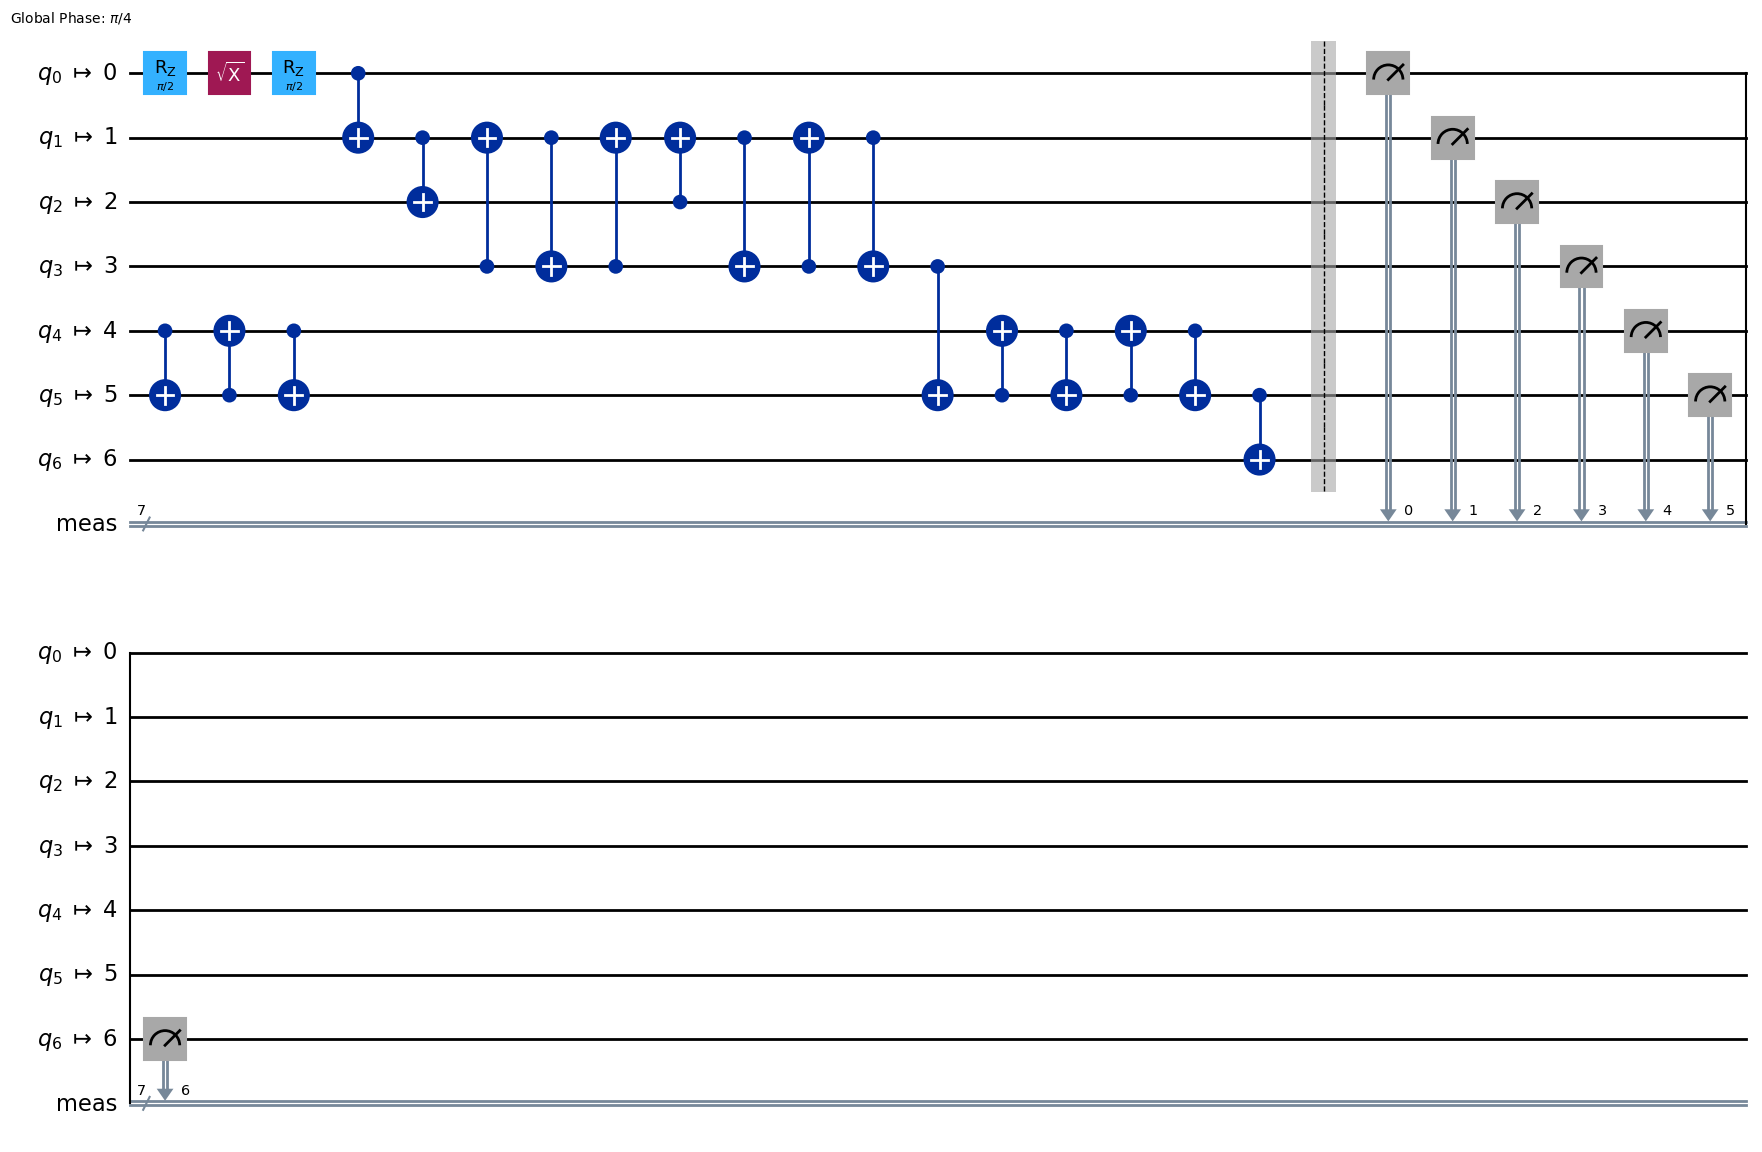

In [14]:
trans_oslo.draw('mpl')

In [29]:
quito_cnot_gates = trans_quito.count_ops().get('cx', 0)
oslo_cnot_gates = trans_oslo.count_ops().get('cx', 0)


print(quito_cnot_gates)
print(oslo_cnot_gates)


7
18


In [ ]:
quito_counts = quito.run(trans_quito, shots=shots).result().get_counts()
oslo_counts = oslo.run(trans_oslo, shots=shots).result().get_counts()

{'10111': 197, '01111': 138, '00000': 3311, '11110': 243, '00100': 64, '11111': 1984, '11101': 630, '00001': 342, '11000': 62, '11011': 132, '00011': 186, '00111': 80, '01100': 12, '00010': 176, '10000': 67, '10100': 18, '01000': 60, '11100': 192, '10101': 56, '01110': 18, '10011': 25, '00110': 14, '01101': 31, '11001': 45, '11010': 20, '00101': 35, '10110': 15, '01001': 8, '10001': 11, '10010': 8, '01010': 4, '01011': 8}
{'0001000': 57, '1111100': 8, '0000000': 3417, '1111111': 3391, '0000101': 47, '0110000': 2, '1000001': 2, '0000111': 32, '1111101': 83, '1011111': 62, '0010000': 125, '1101110': 1, '1000111': 1, '0000001': 55, '1111011': 33, '1100000': 33, '1001111': 2, '0100000': 36, '1000100': 1, '1111010': 24, '0000010': 80, '0111111': 84, '0000110': 1, '0101111': 6, '1111110': 55, '1000000': 150, '0011111': 52, '1101111': 127, '0001100': 1, '0111101': 4, '1110000': 31, '1111000': 16, '1110101': 3, '0001111': 47, '0000100': 19, '1010000': 8, '1000101': 1, '0000011': 6, '0010001': 

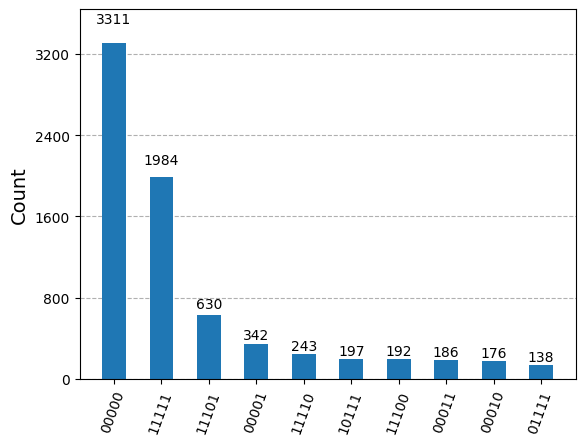

In [16]:
plot_histogram(quito_counts, sort='value_desc', number_to_keep=10)

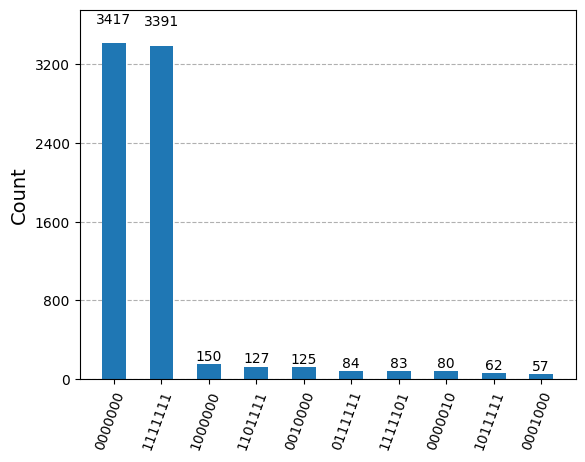

In [17]:
plot_histogram(oslo_counts, sort='value_desc', number_to_keep=10)

(c) Using `plot_circuit_layout`, check the topology (i.e. the connectivity) of both backends. For each backend, design a new quantum circuit that implements the GHZ state using exactly $N-1$ CNOT gates (4 and 6 respectively). Repeat exercise (b), plotting the counts of the original circuit and your new circuit in a single histogram, for both backends.

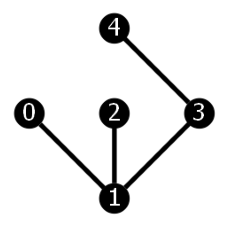

In [18]:
plot_circuit_layout(trans_quito, quito)

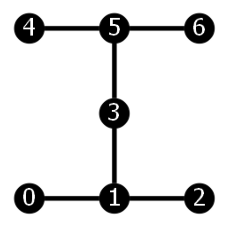

In [19]:
plot_circuit_layout(trans_oslo, oslo)

In [20]:
quito_GHZ = QuantumCircuit(5)

quito_GHZ.h(1)
quito_GHZ.cx(1,0)
quito_GHZ.cx(1,2)
quito_GHZ.cx(1,3)
quito_GHZ.cx(3,4)

print(f'The number of CNOT gates is {quito_GHZ.num_nonlocal_gates()}.')
print(Statevector(quito_GHZ).data)

The number of CNOT gates is 4.
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


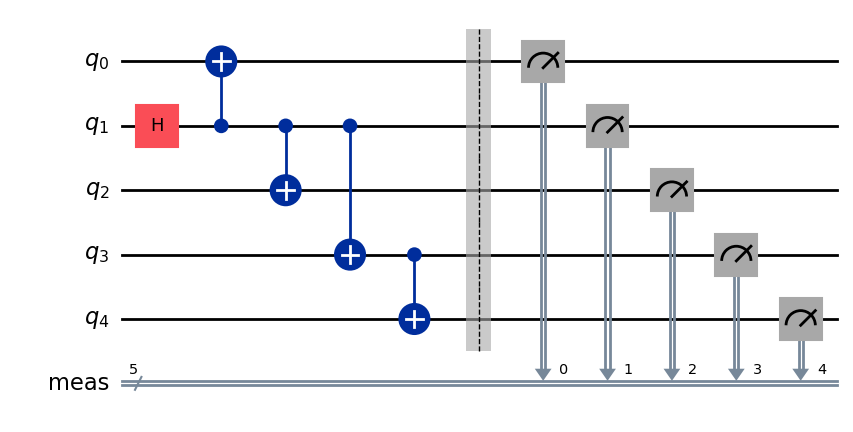

In [21]:
quito_GHZ.measure_all(inplace=True)

quito_GHZ.draw('mpl')

In [22]:
oslo_GHZ = QuantumCircuit(7)

oslo_GHZ.h(3)
oslo_GHZ.cx(3,1)
oslo_GHZ.cx(1,0)
oslo_GHZ.cx(3,5)
oslo_GHZ.cx(1,2)
oslo_GHZ.cx(5,6)
oslo_GHZ.cx(5,4)

print(f'The number of CNOT gates is {oslo_GHZ.num_nonlocal_gates()}.')
print(Statevector(oslo_GHZ).data)


The number of CNOT gates is 6.
[0.70710678+0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.        +0.j
 0.        +0.j 0.        +0.j 0.        +0.j 0.      

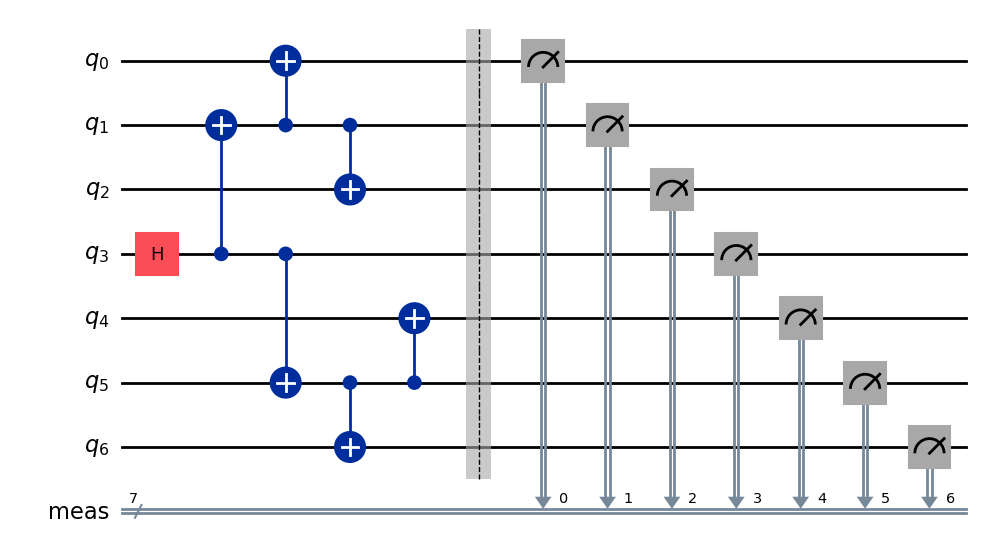

In [23]:
oslo_GHZ.measure_all(inplace=True)
oslo_GHZ.draw('mpl')

In [24]:
trans_quito_opt = transpile(quito_GHZ, backend=quito, optimization_level=0)
trans_oslo_opt = transpile(oslo_GHZ, backend=oslo, optimization_level=0)

quito_results_opt = quito.run(trans_quito_opt, shots=shots).result()
quito_counts_opt = quito_results_opt.get_counts()

oslo_results_opt = oslo.run(trans_oslo_opt, shots=shots).result()
oslo_counts_opt = oslo_results_opt.get_counts()

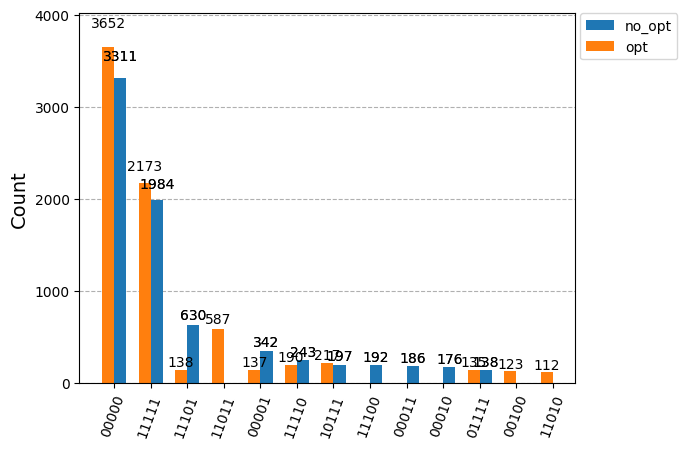

In [25]:
plot_histogram([quito_counts, quito_counts_opt], legend=['no_opt', 'opt'], sort='value_desc', number_to_keep=10)

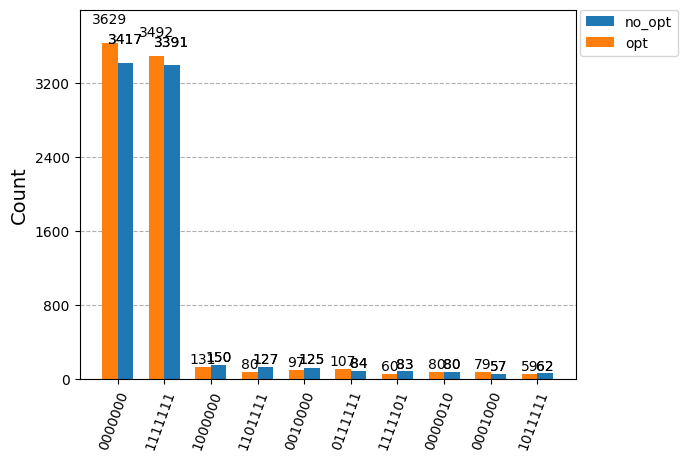

In [26]:
plot_histogram([oslo_counts, oslo_counts_opt], legend=['no_opt', 'opt'], sort='value_desc', number_to_keep=10)